In [ ]:
!pip install requirements.txt

# Aspect-Based Sentiment Analysis using Auxiliary Questions: A Simplified Approach
Assignment Natural Language Processing for course Intelligent Systems

Author: Sabine Warringa

This notebook corresponds to the attached report `report.pdf`.
In short, it first installs the required packages stored in `requirements.txt`. Then, it import the ABSA class. Now, this notebook can be used in two ways:
* (A) Run all models on some predefined set of data, attached to the assignment.
* (B) Use this notebook as a prototype for the tool mentioned in the report


## Imports and ABSA class

In [3]:
!python -m textblob.download_corpora

from sklearn import metrics
import pandas as pd
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from transformers import TFBertForQuestionAnswering #for pytorch
from transformers import pipeline, AutoTokenizer
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

class ABSA:
    def __init__(self, modelnameQA, modelnameSenti, model_id="mymodel"):
        self.model_id = model_id
        self.modelnameQA = modelnameQA
        self.modelnameSenti = modelnameSenti
        self.pipelineQA = self.initQA(modelnameQA)

    def initQA(self, modelname):
        modelQA = TFBertForQuestionAnswering.from_pretrained(modelname)
        tokenizerQA = AutoTokenizer.from_pretrained(modelname)
        pipelineQA = pipeline(
            task="question-answering", model=modelQA, tokenizer=tokenizerQA
        )
        return pipelineQA

    def initSenti(self, modelname="TextBlob"):
        pass

    def trainQA():
        pass

    def trainSenti():
        pass

    def train(df_train):
        pass

    def predictQA(self, df, category_col="cat", review_col="sentence"):
        # Predict the answers to the question about the category
        df = df.copy()
        
        # Convert to question
        df["question"] = df[category_col].apply(
            lambda x: f"What do you think of the {x}?"
        )
        QA_dict_input = {
            "question": df["question"].tolist(),
            "context": df[review_col].tolist(),
        }

        predictions = self.pipelineQA(QA_dict_input)
        df_out = pd.DataFrame(predictions)
        df["QAanswer"] = df_out["answer"]
        df["QAfound"] = df_out["score"] > 0.01 # only consider answers with some degree of certainty
        df.drop(columns=["question"], inplace=True)

        return df

    def predictSenti(self, df, text_col="QAanswer"):
        # Predict the sentiment of the answers that were found, using TextBlob
        df_filtered = df[df["QAfound"] == True]

        df_filtered["sent"] = df_filtered[text_col].apply(
            lambda x: TextBlob(x).sentiment
        )
        df_filtered["SentiPol"] = df_filtered["sent"].apply(lambda x: x.polarity)
        df_filtered["SentiSubj"] = df_filtered["sent"].apply(lambda x: x.subjectivity)
        
        # Transform polarity score into categorical sentiment
        df_filtered["SentiPred"] = pd.cut(
            df_filtered["SentiPol"],
            bins=[-100, -0.01, 0.01, 100],
            labels=["negative", "neutral", "positive"],
        )
        
        # Merge with dataset
        df_temp = df_filtered[["index", "SentiPol", "SentiSubj", "SentiPred"]]
        df = pd.merge(left=df, right=df_temp, how="left", on=["index"])

        return df

    def predict(self, df, category_col="cat", review_col="sentence"):
        # The full sentiment prediction pipeline using QA and TextBlob
        df_1 = self.predictQA(df, category_col, review_col)
        df_2 = self.predictSenti(df_1)
        return df_2

    def evaluate(self, df_train=None, df_test=None, dataset_id="mydataset", save_as_csv=False, path=""):
        # Apply the sentiment prediction phases and evaluate results
        
        df_test = df_test.copy()
        
        dic = {
            "model": [],
            "dataset": [],
            "set": [],
            "perc_found": [],
            "accuracy": [],
            "F1": [],
        }

        # TRAIN MODELS (not applicable in current use case)

        # TEST EVALUATION METRICS
        df_test = self.predict(df_test)

        if save_as_csv:
            df_test.to_csv(f"{path}/{self.model_id}_{dataset_id}.csv")

        dic["perc_found"].append(df_test["QAfound"].mean())
        df_test = df_test[df_test["QAfound"] == True]
        dic["model"].append(self.model_id)
        dic["dataset"].append(dataset_id)
        dic["set"].append("test")
        dic["accuracy"].append(
            metrics.accuracy_score(df_test["cat_pol"], df_test["SentiPred"])
        )
        dic["F1"].append(
            metrics.f1_score(df_test["cat_pol"], df_test["SentiPred"], average="macro")
        )

        return dic


[nltk_data] Downloading package brown to
[nltk_data]     /Users/sabinewarringa/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sabinewarringa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sabinewarringa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sabinewarringa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sabinewarringa/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sabinewarringa/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# (A) Running the models on datasets

In [ ]:
# Import data
# The data should be in the format index,ID,sentence,cat,cat_pol in a df

# RESTAURANT
df_restaurant_raw = pd.read_excel("data/SemEval/restaurant_train.xlsx", 
                               skiprows=2,
                               header=None, 
                               names = ["ID", "cat", "cat_pol", "aspect_from","aspect_pol", "ascept", "aspect_to", "sentence"])

# Prepare data
df_restaurant = df_restaurant_raw[['ID', 'sentence','cat', 'cat_pol']].dropna()
df_restaurant = df_restaurant[df_restaurant['cat_pol'] != 'conflict']
df_restaurant = df_restaurant[df_restaurant['cat'] != 'anecdotes/miscellaneous'].reset_index()

# LAPTOP
df_laptop_raw = pd.read_excel("data/SemEval/laptop_train.xlsx", 
                               skiprows=2,
                               header=None, 
                               names = ["ID", "cat", "cat_pol", "aspect_from","aspect_pol", "ascept", "aspect_to", "sentence"])

# Prepare data
df_laptop_raw = pd.read_excel("data/SemEval/laptop_train.xlsx", skiprows=2, header=None,
                              names=['ID2', 'ID', 'aspect_from', 'aspect_pol', 'aspect', 'aspect_to', 'sentence']).dropna()
df_laptop_raw['aspect'].replace('battery life', 'battery', inplace=True)                            
keep_aspects = (df_laptop_raw['aspect'].value_counts()/len(df_laptop_raw)).head(10).index.tolist()
df_laptop_raw = df_laptop_raw[df_laptop_raw['aspect'].isin(keep_aspects)]
df_laptop_raw.rename(columns={'aspect':'cat', 'aspect_pol':'cat_pol'}, inplace=True)
df_laptop = df_laptop_raw[['ID', 'sentence', 'cat', 'cat_pol']]
df_laptop = df_laptop[df_laptop['cat_pol']!='conflict'].reset_index()

# MAMS
df_MAMS_raw = pd.read_excel("data/MAMS/train.xlsx", skiprows=2, header=None, names=['ID','cat', 'cat_pol','sentence'])

# Prepare data
df_MAMS = df_MAMS_raw[df_MAMS_raw['cat'] != 'miscellaneous'].reset_index()

# Gather which models and datasets to use
dataset_lst = []
dataset_lst.append(('RESTAURANT', df_restaurant))
dataset_lst.append(('LAPTOP', df_laptop))
dataset_lst.append(('MAMS', df_MAMS))

model_lst = []
model_lst.append(('distilbert_cased', 'distilbert-base-cased-distilled-squad'))
model_lst.append(('distilbert_uncased', 'distilbert-base-uncased-distilled-squad'))
model_lst.append(('bert_cased', 'bert-large-cased-whole-word-masking-finetuned-squad'))
model_lst.append(('bert_uncased', 'bert-large-uncased-whole-word-masking-finetuned-squad'))

# Run the models
df_metrics = pd.DataFrame(columns=['model','dataset','set','perc_found','accuracy','F1','runtime'])
for model_id, model_name in model_lst:
    print(f'id = {model_id}, name = {model_name}')
    absa = ABSA(model_name, 'TextBlob', model_id)
    
    for dataset_id, df in dataset_lst:
        print(f'--- dataset = {dataset_id}')
        start = dt.datetime.now()
        dic = absa.evaluate(df_test=df, dataset_id=dataset_id, save_as_csv=True, path='output')
        runtime = dt.datetime.now()-start
        dic['runtime'] = runtime.seconds
        df_dic = pd.DataFrame(dic)
        df_metrics = df_metrics.append(df_dic, ignore_index=True)

df_metrics.to_csv('output/metrics.csv')
df_metrics


### Plotting of results

In [ ]:
output_folder = 'output'

fig, axs = plt.subplots(4, 3, figsize=(30,30))
i=0

dic_plots = {}
for model_id, model_name in model_lst:
    for dataset_id, df in dataset_lst:
        df_plots = pd.read_csv(f'{output_folder}/{model_id}_{dataset_id}.csv')
        dic_plots[f'{model_id}_{dataset_id}'] = df
    
        df_t = df_plots[['cat_pol','SentiPred']].stack(level=-1, dropna=False).reset_index()
        df_t = df_t.rename(columns={'level_0':'index', 'level_1':'Legend',0:'sentiment'})
        df_t = df_t.fillna('not recognized')
        df_t['Legend'] = df_t['Legend'].replace({'cat_pol':'true', 'SentiPred':'predicted'})

        sns.countplot(data=df_t, x='sentiment', hue='Legend', ax=axs.flat[i], order=['negative', 'neutral', 'positive', 'not recognized'])
        axs.flat[i].set_title(f'{model_id} for {dataset_id}')

        i += 1

fig.savefig(f'{output_folder}/fig.png')



# (B) Tool protoype
Important: make sure the class and import cell has been run


Give the path to your file with reviews in CSV. 
Make sure it has at least a column called 'Review' with the review in it in English.

sample_reviews.csv
For which topic(s) do you want to have a summary?
For example: food, or service, or ambiance
-- Topic: food
Add more? (y/n): y
-- Topic: service
Add more? (y/n): n
Use default model? (bert_cased) (y/n) y


All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-cased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


CATEGORY FOOD: 13.3% negative, 46.7% positive, 40.0% neutral


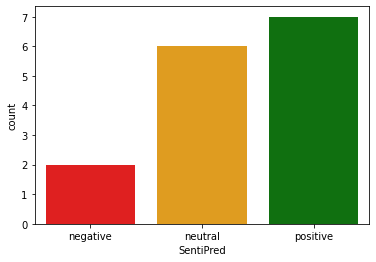

NEGATIVE REVIEWS about food:
* But the staff was so horrible to us.
* To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.

NEUTRAL REVIEWS about food:
* For those that go once and don't enjoy it, all I can say is that they just don't get it.
* He has visited Thailand and is quite expert on the cuisine.
* I would definitely recommend Mary's and am making it one of my regular neighborhood haunts.
* It took half an hour to get our check, which was perfect since we could sit, have drinks and talk!
* They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.
* Where Gabriela personaly greets you and recommends you what to eat.

POSITIVE REVIEWS about food:
* It is very overpriced and not very tasty.
* Nevertheless the food itself is pretty good.
* Not only 

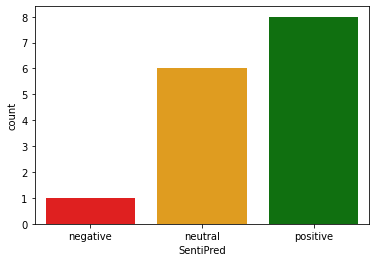

NEGATIVE REVIEWS about service:
* But the staff was so horrible to us.

NEUTRAL REVIEWS about service:
* For those that go once and don't enjoy it, all I can say is that they just don't get it.
* He has visited Thailand and is quite expert on the cuisine.
* I would definitely recommend Mary's and am making it one of my regular neighborhood haunts.
* It took half an hour to get our check, which was perfect since we could sit, have drinks and talk!
* They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.
* Where Gabriela personaly greets you and recommends you what to eat.

POSITIVE REVIEWS about service:
* It is very overpriced and not very tasty.
* Nevertheless the food itself is pretty good.
* Not only was the food outstanding, but the little 'perks' were great.
* Our agreed favorite is the orrechiete with sausage and chicken (usually the waiter

In [5]:
# Set the default models
model_id = 'bert_cased'
model_name = 'bert-large-cased-whole-word-masking-finetuned-squad'

# Ask for user input
app_input = input(f"""
Give the path to your file with reviews in CSV. 
Make sure it has at least a column called 'Review' with the review in it in English.

""")

topic_lst = []
print('For which topic(s) do you want to have a summary?')
print('For example: food, or service, or ambiance')
more = True
while (more == True):
    topic = input('-- Topic: ')
    topic_lst.append(topic)
    more_input = input('Add more? (y/n): ')
    if more_input != 'y':
        more = False

def_input = input(f'Use default model? ({model_id}) (y/n) ')
if def_input != 'y':
    print(f'''You can choose between:
    * 1 distilbert-base-cased-distilled-squad
    * 2 distilbert-base-uncased-distilled-squad
    * 3 bert-large-cased-whole-word-masking-finetuned-squad
    * 4 bert-large-uncased-whole-word-masking-finetuned-squad
    ''')
    
    choice = int(input('Type your choice (1/2/3/4): '))
    if choice == 1:
        model_id = 'distilbert_cased'
        model_name = 'distilbert-base-cased-distilled-squad'
    elif choice == 2:
        model_id = 'distilbert_uncased'
        model_name = 'distilbert-base-uncased-distilled-squad'
    elif choice == 3:
        model_id = 'bert_cased'
        model_name = 'bert-large-cased-whole-word-masking-finetuned-squad'
    elif choice == 4:
        model_id = 'bert_uncased'
        model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'     
        
df_app = pd.read_csv(app_input, sep='delimiter', header=0)

# Add category columns
df_app['cat'] = [topic_lst for i in range(0, len(df_app))]
df_app = df_app.explode('cat').reset_index(drop=True).reset_index()

# Run ABSA
absa = ABSA(model_name, 'TextBlob', model_id)
df_pred = absa.predict(df_app, category_col='cat', review_col='Review')

# Print summary
for cat in topic_lst:
    df_cat = df_pred[df_pred['cat'] == cat].dropna()
    perc = (df_cat['SentiPred'].value_counts()/len(df_cat))*100
    print(f'CATEGORY {cat.upper()}: {round(perc["negative"],1)}% negative, {round(perc["positive"],1)}% positive, {round(perc["neutral"],1)}% neutral')
    plt.figure()
    df_cat['Sentiment'] = df_cat['SentiPred']
    sns.countplot(data=df_cat['Sentiment'], x=df_cat['SentiPred'], palette=['r', 'orange', 'g'], )
    plt.show()
    
    for s in df_cat['SentiPred'].unique():
        print(f'{s.upper()} REVIEWS about {cat}:')
        df_s = df_cat[df_cat['SentiPred']==s]
        for rev in df_s['Review']:
            print(f'* {rev}')
        print('')
    
    print('-----')